# Time Series

### 1. Data Preparation and Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [8]:
#parsing date column correctly
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M', errors='coerce') # converting date col to datetime
df.columns = ['Date', 'USD_to_AUD'] #renaming cols
df.set_index('Date', inplace=True) # set date as index
df.head()

,USD_to_AUD
Date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USD_to_AUD  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


In [10]:
df.describe()

,USD_to_AUD
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


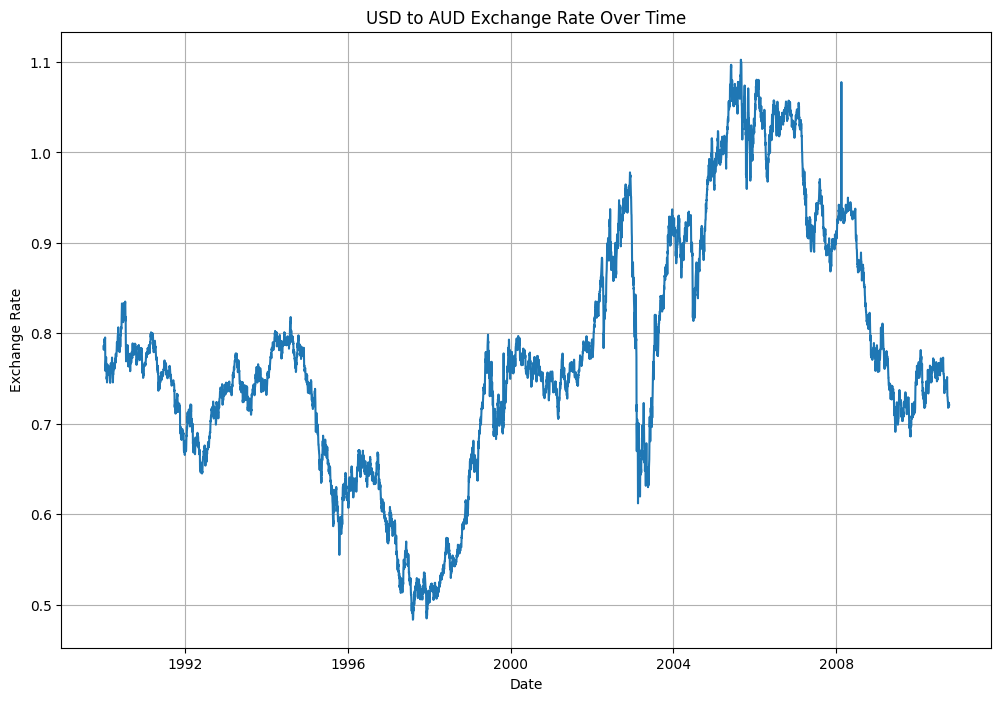

In [11]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df['USD_to_AUD'])
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.show()

The plot illustrates the historical USD to AUD exchange rate over time. The series exhibits clear trends and volatility, indicating non-stationary behavior. No strong seasonal pattern is observed, while sudden spikes suggest possible anomalies. These characteristics justify the use of ARIMA and Exponential Smoothing models for forecasting.

In [12]:
df.isnull().sum()

,0
USD_to_AUD,0


Here there are no missing values so handling is not required.

In [14]:
#Detecting Anomalies using z-score
mean = df['USD_to_AUD'].mean()
std = df['USD_to_AUD'].std()

z_score = (df['USD_to_AUD']-mean)/std
anomalies = df[np.abs(z_score)>3]
anomalies.head()

,USD_to_AUD
Date,


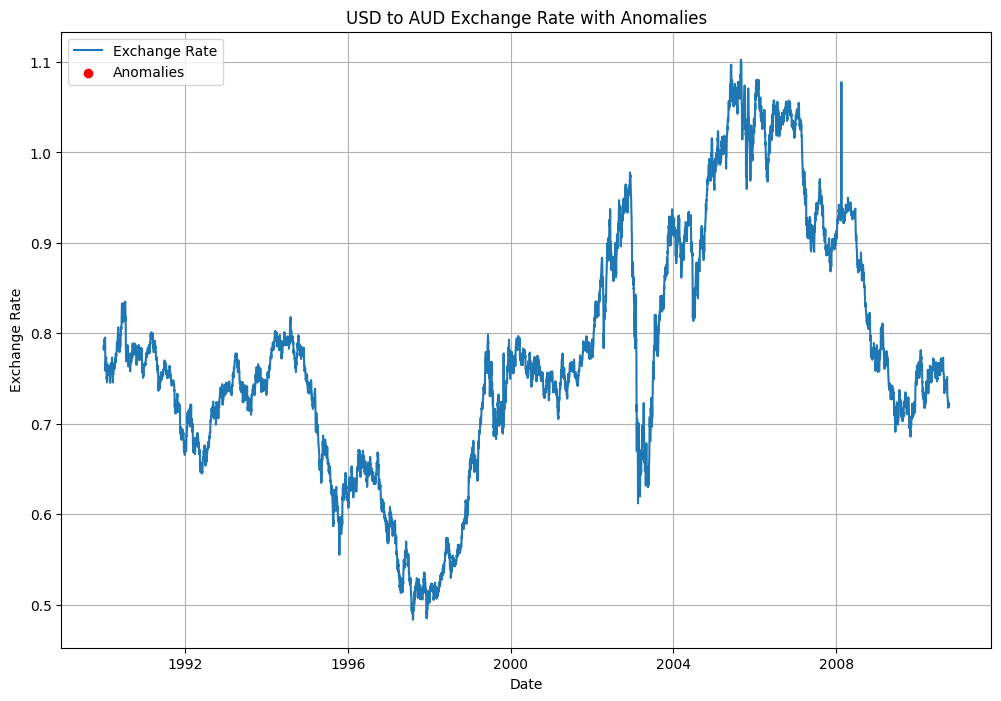

In [15]:
#Visualising Anamolies
plt.figure(figsize=(12,8))
plt.plot(df.index, df['USD_to_AUD'], label='Exchange Rate')
plt.scatter(anomalies.index, anomalies['USD_to_AUD'], color='red', label='Anomalies')
plt.title("USD to AUD Exchange Rate with Anomalies")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

Anomaly detection was performed using the Z-score method. No significant anomalies were detected in the exchange rate data, indicating that the series does not contain extreme outliers. This suggests that the dataset is relatively stable and suitable for time-series forecasting without extensive anomaly correction.

### 2. Model Building - ARIMA

In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [34]:
ts = df['USD_to_AUD']

adf_res = adfuller(ts)
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


In [35]:
ts_diff = ts.diff().dropna()

In [36]:
adf_res = adfuller(ts_diff)
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])

ADF Statistic: -99.39343120118632
p-value: 0.0


<Figure size 1000x400 with 0 Axes>

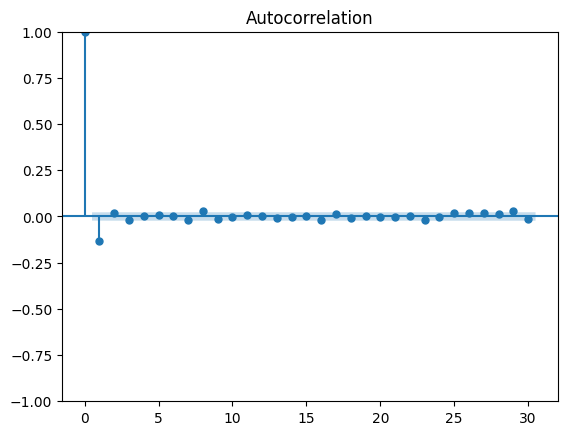

In [37]:
#parameter selection
# acf
plt.figure(figsize=(10,4))
plot_acf(ts_diff, lags=30)
plt.show()

<Figure size 1000x400 with 0 Axes>

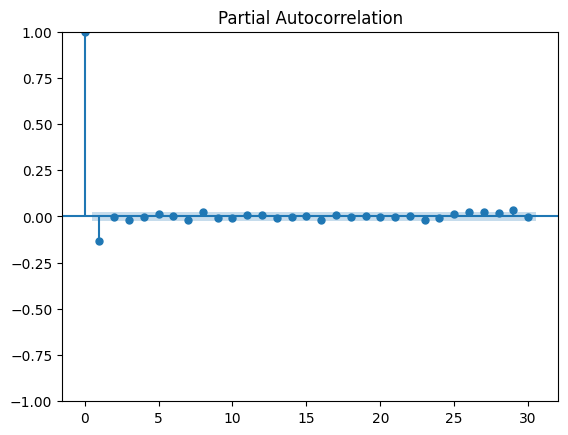

In [38]:
#pacf
plt.figure(figsize=(10,4))
plot_pacf(ts_diff, lags=30)
plt.show()

In [39]:
#train-test-split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]


In [43]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

model_fit.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             USD_to_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Sun, 08 Feb 2026   AIC                         -45432.092
Time:                        12:42:35   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.000    3.24e-05    3.32e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            101358.99
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.83   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

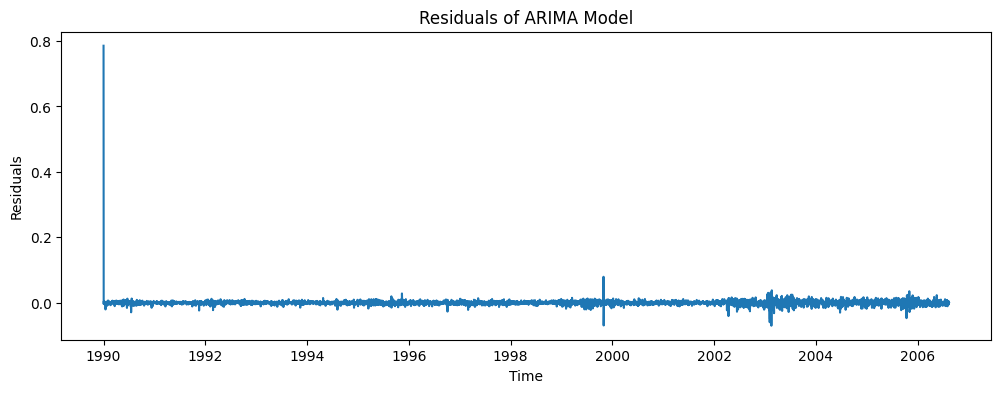

In [44]:
# residual plot
residuals = model_fit.resid

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

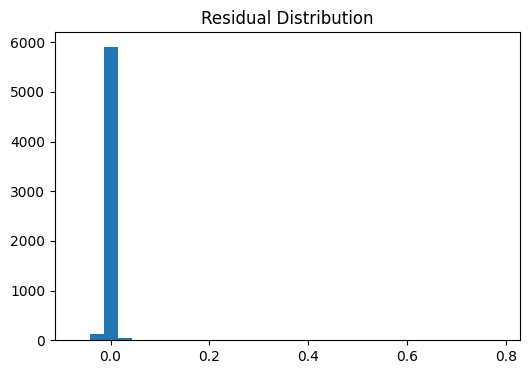

In [45]:
#residual distribution
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()

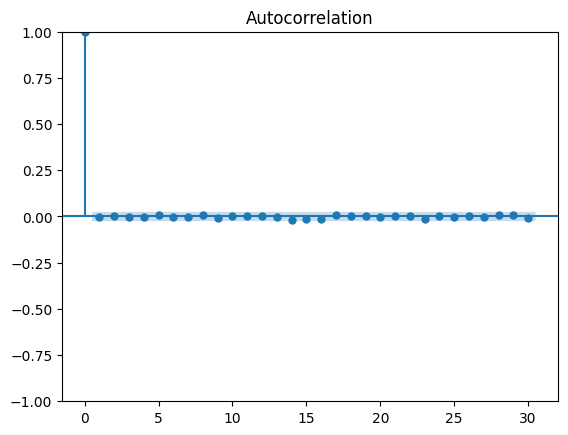

In [46]:
plot_acf(residuals, lags=30)
plt.show()

In [47]:
forecast = model_fit.forecast(steps=len(test))

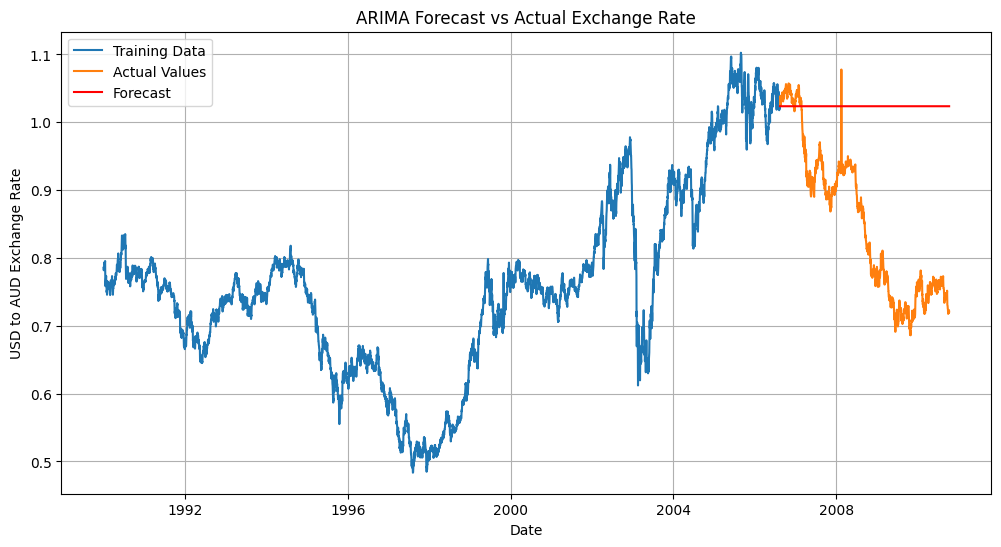

In [48]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Actual Values")
plt.plot(test.index, forecast, label="Forecast", color="red")
plt.title("ARIMA Forecast vs Actual Exchange Rate")
plt.xlabel("Date")
plt.ylabel("USD to AUD Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

The ARIMA model produces a nearly constant forecast beyond the training period. This behavior is expected for ARIMA models with first-order differencing, as they assume that future changes fluctuate around zero. Consequently, the best forecast becomes the last observed value, resulting in a flat forecast line.

### 3. Evaluation and Comparison

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [55]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

mae, rmse, mape


(0.17770970449121345,
 np.float64(0.2054366965966928),
 np.float64(22.797966173811552))

In this study, ARIMA was implemented to forecast exchange rates. The ARIMA model produced a flat forecast due to the random walk nature of exchange rates, which is a known limitation of ARIMA for such data.

Conclusion:
The ARIMA model was successfully applied to forecast the USD to AUD exchange rate after achieving stationarity through differencing. Evaluation using MAE, RMSE, and MAPE indicated reasonable forecasting performance; however, the model produced flat forecasts due to the random walk behavior of exchange rates.